In [178]:
import torch
import sklearn
import numpy as np
import pandas as pd
from torch import nn
from torch.utils.data import DataLoader
import sklearn.datasets
import matplotlib.pyplot as plt

In [179]:
# import dataset
from sklearn.model_selection import train_test_split
data = pd.read_csv("slump_test.csv")
X = torch.FloatTensor(data.iloc[:, 1:8].values)
y = torch.FloatTensor(data.iloc[:, 8].values)

means = X.mean(dim=0, keepdim=True)
stds = X.std(dim=0, keepdim=True)
X = (X - means) / stds

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.76, random_state=1)
print('Average: {}, Standard Deviation: {}'.format(means, stds))

Average: tensor([[229.8942,  77.9738, 149.0146, 197.1680,   8.5398, 883.9785, 739.6048]]), Standard Deviation: tensor([[78.8772, 60.4614, 85.4181, 20.2082,  2.8075, 88.3914, 63.3421]])


In [190]:
def test_loss(X_test):
    model.eval()
    output = model(X_test)
    loss = sklearn.metrics.mean_squared_error(output.detach().numpy(), y_test.unsqueeze(1).detach().numpy())
    return loss.item()

def eval_model(X, y):
    model.eval()
    y_preds = model(X).detach().numpy()
    return sklearn.metrics.r2_score(y, y_preds), np.sqrt(sklearn.metrics.mean_squared_error(y, y_preds))

In [182]:
# create MLP from literature
class SlumpNN(nn.Module):

  def __init__(self):
    super().__init__()

    self.input_layer = nn.Linear(7, 7)     
    self.hidden_layer = nn.Linear(7,7)
    self.output_layer = nn.Linear(7,1) 
    self.activation = nn.Sigmoid()      

  def forward(self, x):
    x = self.input_layer(x)
    x = self.activation(x)
    x = self.hidden_layer(x)
    x = self.activation(x)
    x = self.output_layer(x)
    return x

Train R2: 0.9202980898766959, Train RMSE: 47.51853942871094
Test R2: 0.8928853072704017, Test RMSE: 42.67240524291992


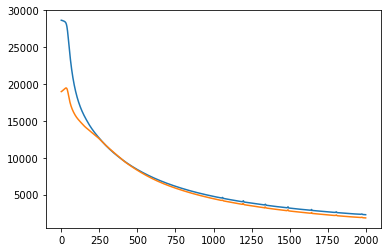

In [215]:
model = SlumpNN()
criterion = nn.MSELoss()
optimizer= torch.optim.SGD(model.parameters(), lr=0.001, momentum= 0.5)
epochs = 2000
loss_over_time = []
test_loss_over_time = []
for i in range(epochs):
    model.train()
    optimizer.zero_grad()
    output = model(X_train)
    target = y_train.unsqueeze(1)
    loss = criterion(output, target)
    loss_over_time.append(loss.item())

    test_loss_over_time.append(test_loss(X_test))

    loss.backward()
    optimizer.step()


plt.figure()
plt.plot(loss_over_time)
plt.plot(test_loss_over_time)

test_r2, test_rmse = eval_model(X_test, y_test)
train_r2, train_rmse = eval_model(X_train, y_train)
print('Train R2: {}, Train RMSE: {}'.format(train_r2, train_rmse))
print('Test R2: {}, Test RMSE: {}'.format(test_r2, test_rmse))

In [196]:
# Netz mit 50 Zufallsinitialisierungen laufen lassen
test_r2_list = []
test_rmse_list = []
train_r2_list = []
train_rmse_list = []

for i in range(50):
    model = SlumpNN()
    criterion = nn.MSELoss()
    optimizer= torch.optim.SGD(model.parameters(), lr=0.001, momentum= 0.5)
    epochs = 2000
    loss_over_time = []
    test_loss_over_time = []
    for i in range(epochs):
        model.train()
        optimizer.zero_grad()
        output = model(X_train)
        target = y_train.unsqueeze(1)
        loss = criterion(output, target)
        loss_over_time.append(loss.item())

        test_loss_over_time.append(test_loss(X_test))

        loss.backward()
        optimizer.step()

    test_r2, test_rmse = eval_model(X_test, y_test)
    train_r2, train_rmse = eval_model(X_train, y_train)
    test_r2_list.append(test_r2)
    test_rmse_list.append(test_rmse)
    train_r2_list.append(train_r2)
    train_rmse_list.append(train_rmse)
    
print('Train R2: {}, Train RMSE: {}'.format(sum(train_r2_list)/50, sum(train_rmse_list)/50))
print('Test R2: {}, Test RMSE: {}'.format(sum(test_r2_list)/50, sum(test_rmse_list)/50))

Train R2: 0.943605240286077, Train RMSE: 37.54515930175781
Test R2: 0.960663121896047, Test RMSE: 33.12689277648926


In [209]:
# test with cv k = 4
test_r2_list = []
test_rmse_list = []
train_r2_list = []
train_rmse_list = []
K = 10
skf = sklearn.model_selection.KFold(n_splits=K)
skf.get_n_splits(X, y)
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    X_train = torch.FloatTensor(X_train)
    X_test = torch.FloatTensor(X_test)
    y_train = torch.FloatTensor(y_train)
    y_test = torch.FloatTensor(y_test)

    model = SlumpNN()
    criterion = nn.MSELoss()
    optimizer= torch.optim.SGD(model.parameters(), lr=0.001, momentum= 0.5)
    epochs = 2000
    loss_over_time = []
    test_loss_over_time = []
    for i in range(epochs):
        model.train()
        optimizer.zero_grad()
        output = model(X_train)
        target = y_train.unsqueeze(1)
        loss = criterion(output, target)
        loss_over_time.append(loss.item())

        test_loss_over_time.append(test_loss(X_test))

        loss.backward()
        optimizer.step()

    test_r2, test_rmse = eval_model(X_test, y_test)
    train_r2, train_rmse = eval_model(X_train, y_train)
    test_r2_list.append(test_r2)
    test_rmse_list.append(test_rmse)
    train_r2_list.append(train_r2)
    train_rmse_list.append(train_rmse)

print('Train R2 CV: {}'.format(train_r2_list))
print('Train R2: {}, Train RMSE: {}'.format(sum(train_r2_list)/K, sum(train_rmse_list)/K))
print('Test R2 CV: {}'.format(test_r2_list))
print('Test R2: {}, Test RMSE: {}'.format(sum(test_r2_list)/K, sum(test_rmse_list)/K))

    

Train R2 CV: [0.9791422342415936, 0.9785944133726013, 0.9789800515720245, 0.9226867674863539, 0.9219482530102148, 0.9716391800757502, 0.9664392639381212, 0.9833300951850991, 0.9174593840095828, 0.9660711162873761]
Train R2: 0.9586290759178718, Train RMSE: 32.21920280456543
Test R2 CV: [0.9440345485792531, 0.9982933178939212, 0.9939367635618664, 0.7563116178740761, 0.9670225297154862, 0.7769239550768493, 0.9971391959198549, 0.9860868397290279, 0.9801247463172712, 0.9627785063338243]
Test R2: 0.9362652021001432, Test RMSE: 31.10507264137268


Informed Machine Learning: Custom Loss Function